## Calculating return period for cyclones in Mozambique

We're looking to calculate the return period for cyclones of a given threshold speed over select provinces in Mozambique. We'd like to have both: 
- An overall return period across all selected provinces
- A per-province return period

In [21]:
%load_ext jupyter_black
import geopandas as gpd
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path
from shapely.geometry import LineString
import os
from datetime import datetime

load_dotenv()
AA_DATA_DIR = os.getenv("AA_DATA_DIR")
AA_DATA_DIR_NEW = os.getenv("AA_DATA_DIR_NEW")
THRESHOLD_SPEED_OPT1 = 80
THRESHOLD_SPEED_OPT2 = 115
ADMS = ["Sofala", "Inhambane", "Nampula", "Zambezia"]

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## 1. Data loading and preparation

We'll start by loading in the required data sources below. We need the ADM1 boundaries (provinces) and the [IBTrACS](https://www.ncei.noaa.gov/products/international-best-track-archive) `.shp` of cyclone tracks. We'll select only the provinces of interest from the admin boundaries file.

In [3]:
adm1_path = (
    Path(AA_DATA_DIR)
    / "public"
    / "raw"
    / "moz"
    / "cod_ab"
    / "moz_admbnda_adm1_ine_20190607.shp"
)
gdf_adm1 = gpd.read_file(adm1_path)
gdf_sel = gdf_adm1[gdf_adm1.ADM1_PT.isin(ADMS)]

# TODO: Replace with local path
ibtracs_path = adm1_path = Path(AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
points_path = Path(
    ibtracs_path / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)
lines_path = Path(
    ibtracs_path / "IBTrACS.SI.list.v04r01.lines/IBTrACS.SI.list.v04r01.lines.shp"
)

gdf_points = gpd.read_file(points_path)
gdf_lines = gpd.read_file(lines_path)

In [11]:
# TODO: Some additional data shared from Tristan that might be useful
# wmo_speeds_path = Path(AA_DATA_DIR_NEW) / "public" / "processed" / "glb" / "ibtracs" / "ibtracs_with_wmo_wind.parquet"
# df_wmo_speeds = pd.read_parquet(wmo_speeds_path)

Let's also check that both datasets have the same CRS. Then we can select only the points within the polygons. We'll also clean up the columns and make sure points are sorted by time.

In [4]:
assert gdf_points.crs == gdf_sel.crs == gdf_lines.crs
gdf_points_sel = gpd.sjoin(gdf_points, gdf_sel, how="inner", predicate="within")
gdf_lines_sel = gpd.sjoin(gdf_lines, gdf_sel, how="inner", predicate="within")
gdf_points_sel_ = gdf_points_sel[
    ["ADM1_PT", "NAME", "ISO_TIME", "REU_WIND", "WMO_WIND", "geometry"]
].sort_values("ISO_TIME")

And plot for a basic sanity check

<Axes: >

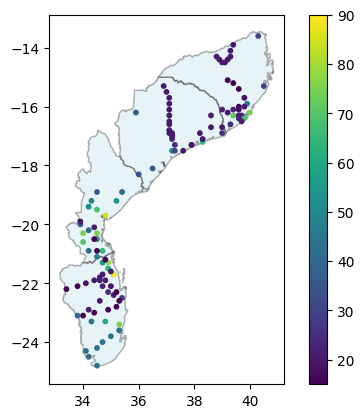

In [7]:
ax = gdf_sel.plot(color="lightblue", edgecolor="black", alpha=0.3)
gdf_points_sel_.plot(ax=ax, column="REU_WIND", markersize=10, legend=True)

Now we also want to get the maximum speed per storm track. 

**TODO: Interpolate to greater temporal frequency (eg. 30 mins)**

In [8]:
lines = []
for name, group in gdf_points_sel_.groupby("NAME"):
    # TODO: Interpolate to avoid groups of only 1 point
    if len(group) > 1:
        line = LineString(group["geometry"].tolist())
        lines.append(
            {"NAME": name, "geometry": line, "max_speed": group["REU_WIND"].max()}
        )

gdf_tracks_joined = gpd.GeoDataFrame(lines, crs="EPSG:4326")

And plot again to sanity check

<Axes: >

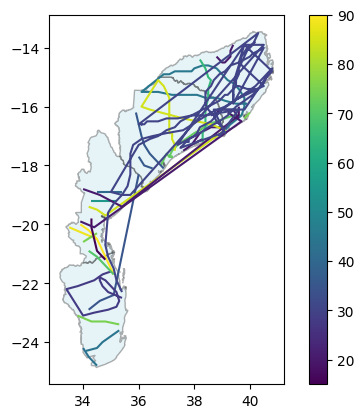

In [9]:
ax = gdf_sel.plot(color="lightblue", edgecolor="black", alpha=0.3)
gdf_tracks_joined.plot(ax=ax, column="max_speed", markersize=10, legend=True)

## 2. Return period calculation

How often do storms reach 80km/hr within these provinces?

In [48]:
def calculate_storm_return_period(df, wind_speed_kmh, start_year):
    # Conversion factor from kilometers per hour to knots
    kmh_to_knots = 1 / 1.852

    # Convert the given speed from km/h to knots
    speed_knots = wind_speed_kmh * kmh_to_knots

    # Extract the year from the 'ISO_TIME' column
    df["year"] = df["ISO_TIME"].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year
    )

    # Filter the DataFrame for records from the start year and with wind speed above the threshold
    df_filtered = df[(df["year"] >= start_year) & (df["REU_WIND"] >= speed_knots)]

    # Calculate the total number of years in the filtered DataFrame
    yr_len = max(df_filtered["year"]) - min(df_filtered["year"]) + 1

    # Count unique storms
    unique_storms = df_filtered["NAME"].nunique()

    # Calculate the combined return period
    combined_return_period = yr_len / unique_storms

    print(
        f"The combined return period of storms over {wind_speed_kmh}km/h is 1-in-{round(combined_return_period, 1)} years."
    )

    # Calculate return periods for each admin region
    admin_return_periods = {}

    grouped = df_filtered.groupby("ADM1_PT")
    for admin, group in grouped:
        admin_unique_storms = group["NAME"].nunique()
        admin_yr_len = max(group["year"]) - min(group["year"]) + 1
        admin_return_period = admin_yr_len / admin_unique_storms
        admin_return_periods[admin] = admin_return_period

        print(
            f"The return period of storms over {wind_speed_kmh}km/h in {admin} is 1-in-{round(admin_return_period, 1)} years."
        )

In [50]:
calculate_storm_return_period(df=gdf_points_sel_, wind_speed_kmh=80, start_year=1998)

The combined return period of storms over 80km/h is 1-in-2.2 years.
The return period of storms over 80km/h in Inhambane is 1-in-5.0 years.
The return period of storms over 80km/h in Nampula is 1-in-3.0 years.
The return period of storms over 80km/h in Sofala is 1-in-3.7 years.
The return period of storms over 80km/h in Zambezia is 1-in-1.0 years.


In [47]:
calculate_storm_return_period(df=gdf_points_sel_, wind_speed_kmh=115, start_year=1998)

The combined return period of storms over 115km/h is 1-in-2.8 years.
The return period of storms over 115km/h in Inhambane is 1-in-5.0 years.
The return period of storms over 115km/h in Nampula is 1-in-1.0 years.
The return period of storms over 115km/h in Sofala is 1-in-5.5 years.
The return period of storms over 115km/h in Zambezia is 1-in-1.0 years.
